In [1]:
% matplotlib inline

import matplotlib
import numpy as np
import sys

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict

if "../" not in sys.path:
    sys.path.append("../")
from envs.blackjack import BlackjackEnv

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.

    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """

    def policy_fn(observation):
        best_action = np.argmax(Q[observation])
        random_action_prob = epsilon / nA
        return np.array([random_action_prob if a != best_action else random_action_prob + 1.0 - epsilon for a, value in
                         enumerate(Q[observation])])

    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.

    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for _ in xrange(num_episodes):
        episode = []

        s = env.reset()
        while True:
            a_probs = policy(s)
            a = np.random.choice(np.arange(len(a_probs)), p=a_probs)
            s_prime, reward, done, info = env.step(a)

            episode.append((s, a, reward))

            if done:
                break

            s = s_prime

        state_action_set = set([(s, a) for s, a, reward in episode])
        for (s, a) in state_action_set:
            first_i = next(i for i, episode_step in enumerate(episode) if episode_step[0] == s and episode_step[1] == a)
            G = sum(episode_step[2] * (discount_factor ** i) for i, episode_step in enumerate(episode[first_i:]))

            pair = (s, a)
            returns_sum[pair] += G
            returns_count[pair] += 1.0
            Q[s][a] = returns_sum[pair] / returns_count[pair]

    return Q, policy

In [5]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

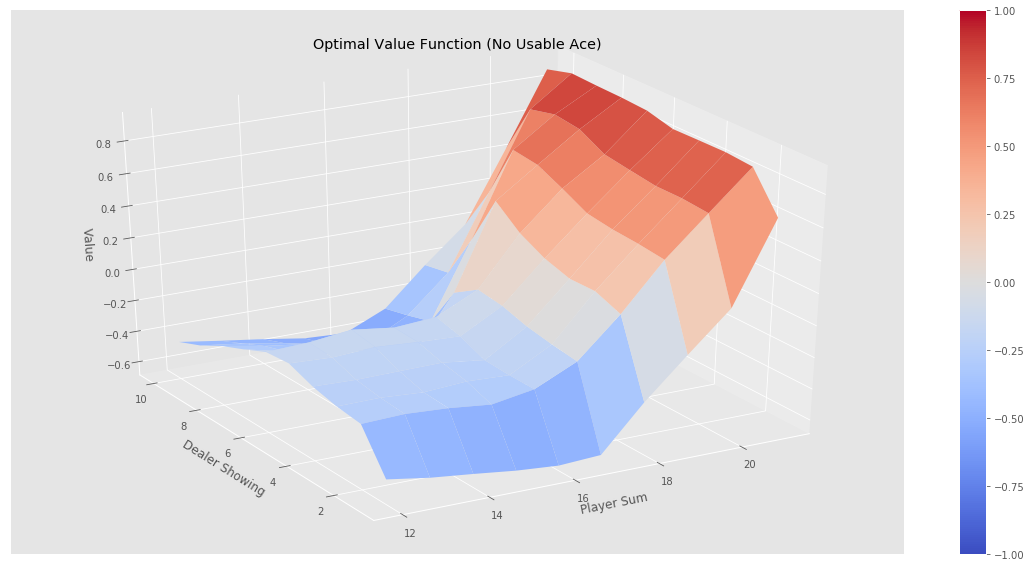

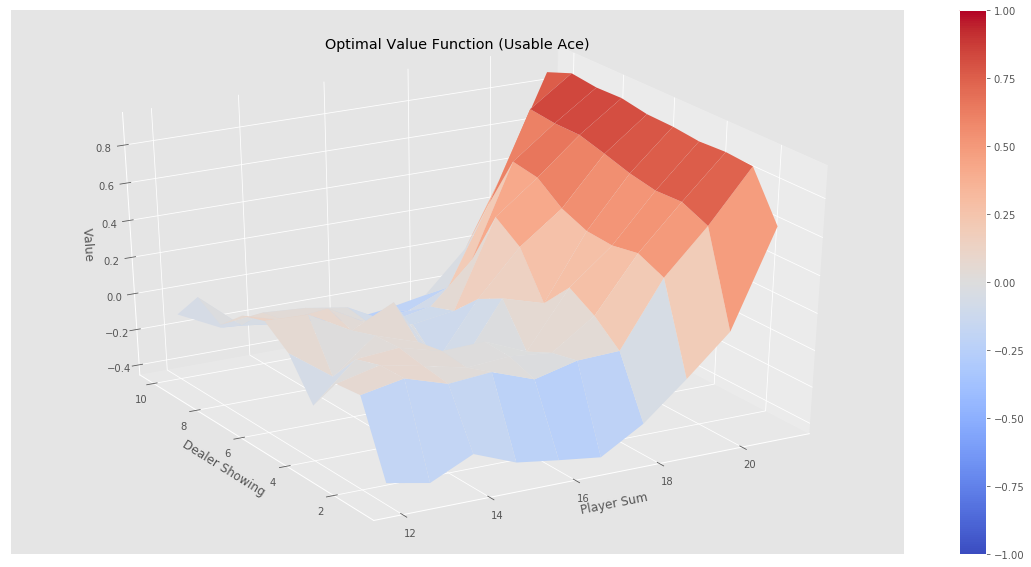

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")